In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import openvino
import ngraph as ng
import numpy as np
from openvino.inference_engine import IECore

In [2]:
%matplotlib notebook

C:\Users\mkowalski\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
camera = cv2.VideoCapture(0)

def grab_frame():
    ret, frame = camera.read()
    return frame

In [4]:
face_model_xml = "face-detection-adas-0001\\FP32\\face-detection-adas-0001.xml"
face_model_bin = "face-detection-adas-0001\\FP32\\face-detection-adas-0001.bin"

attr_model_xml = "age-gender-recognition-retail-0013\\FP32\\age-gender-recognition-retail-0013.xml"
attr_model_bin = "age-gender-recognition-retail-0013\\FP32\\age-gender-recognition-retail-0013.bin"

pose_model_xml = "head-pose-estimation-adas-0001\\FP32\\head-pose-estimation-adas-0001.xml"
pose_model_bin = "head-pose-estimation-adas-0001\\FP32\\head-pose-estimation-adas-0001.bin"

In [5]:
ie = IECore()

face_net = ie.read_network(model = face_model_xml, weights = face_model_bin)
attr_net = ie.read_network(model = attr_model_xml, weights = attr_model_bin)
pose_net = ie.read_network(model = pose_model_xml, weights = pose_model_bin)

face_exec_net = ie.load_network(network = face_net, device_name = "CPU")
attr_exec_net = ie.load_network(network = attr_net, device_name = "CPU")
pose_exec_net = ie.load_network(network = pose_net, device_name = "CPU")

In [6]:
fh, fw = 384, 672
ah, aw = 62, 62
ph, pw = 60, 60

<IPython.core.display.Javascript object>


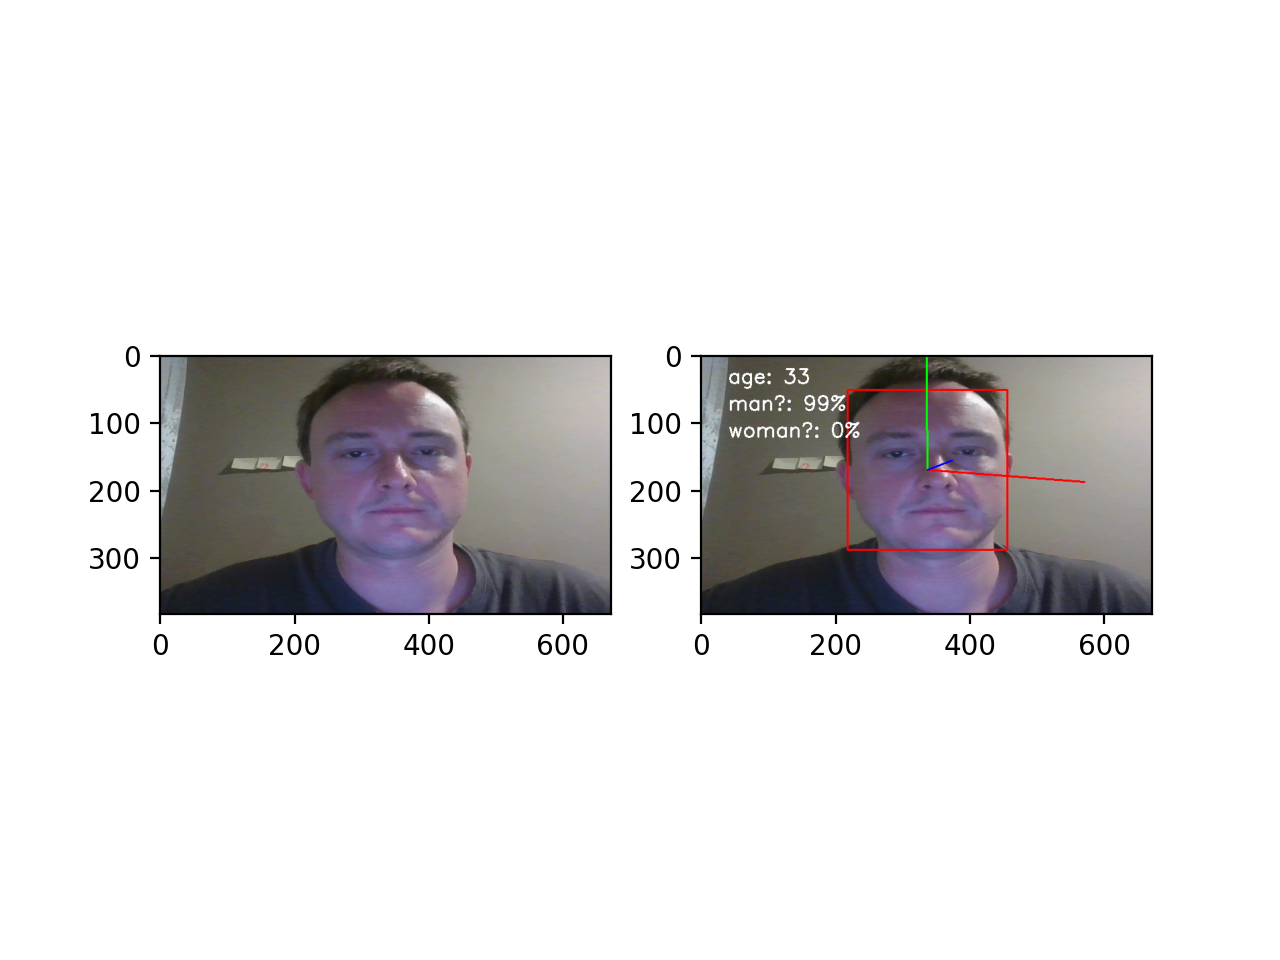

In [7]:
#create two subplots
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

#create two image plots
frame = cv2.resize(grab_frame(), (fw, fh))
im1 = ax1.imshow(frame)
im2 = ax2.imshow(frame)
font = cv2.FONT_HERSHEY_SIMPLEX

def update(i):
    frame = cv2.resize(grab_frame(), (fw, fh))
    
    imin = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    imout = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    
    # face detection
    images = np.ndarray(shape = (1, 3, fh, fw))
    images[0] = frame.transpose((2, 0, 1))
        
    data = {}
    data["data"] = images
    face_data = face_exec_net.infer(inputs = data)
    
    xmin = int(face_data["detection_out"][0][0][0][3] * fw)
    ymin = int(face_data["detection_out"][0][0][0][4] * fh)
    xmax = int(face_data["detection_out"][0][0][0][5] * fw)
    ymax = int(face_data["detection_out"][0][0][0][6] * fh)
    cv2.rectangle(imout, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    
    # attributes detection
    images = np.ndarray(shape = (1, 3, ah, aw))
    images[0] = cv2.resize(frame[ymin:ymax, xmin:xmax], (aw, ah)).transpose((2, 0, 1))

    data = {}
    data["data"] = images
    attr_data = attr_exec_net.infer(inputs = data)
    
    age = int(attr_data["age_conv3"][0][0][0][0] * 100)
    man = int(attr_data["prob"][0][1][0][0] * 100)
    wom = int(attr_data["prob"][0][0][0][0] * 100)
    cv2.putText(imout,"age: " + str(age),(40,40), font, 1,(255,255,255),2)
    cv2.putText(imout,"man?: " + str(man) + "%",(40,80), font, 1,(255,255,255),2)
    cv2.putText(imout,"woman?: " + str(wom) + "%",(40,120), font, 1,(255,255,255),2)
    
    # pitch detection
    images = np.ndarray(shape = (1, 3, ph, pw))
    images[0] = cv2.resize(frame[ymin:ymax, xmin:xmax], (pw, ph)).transpose((2, 0, 1))
    
    data = {}
    data["data"] = images
    pitch_data = pose_exec_net.infer(inputs = data)
    
    yaw = pitch_data['angle_y_fc'][0][0]
    pitch = pitch_data['angle_p_fc'][0][0]
    roll = pitch_data['angle_r_fc'][0][0]
        
    sinY = np.sin(yaw * np.pi / 180.0);
    sinP = np.sin(pitch * np.pi / 180.0);
    sinR = np.sin(roll * np.pi / 180.0);

    cosY = np.cos(yaw * np.pi / 180.0);
    cosP = np.cos(pitch * np.pi / 180.0);
    cosR = np.cos(roll * np.pi / 180.0);
        
    size = xmax - xmin;
    xCenter = xmin + int((xmax - xmin) / 2);
    yCenter = ymin + int((ymax - ymin) / 2);
    
    cv2.line(imout, (xCenter, yCenter), (xCenter + int(size * cosR * cosY + sinY * sinP * sinR), yCenter + int(size * cosP * sinR)), (255, 0, 0), 2)
    cv2.line(imout, (xCenter, yCenter), (xCenter + int(size * cosR * sinY * sinP + cosY * sinR), yCenter - int(size * cosP * cosR)), (0, 255, 0), 2)
    cv2.line(imout, (xCenter, yCenter), (xCenter + int(size * sinY * cosP), yCenter + int(size * sinP)), (0, 0, 255), 2)
    
    im1.set_data(imin)
    im2.set_data(imout)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap1.release()

ani = FuncAnimation(plt.gcf(), update, interval=10)
plt.show()